In [1]:
from airline_revenue_analytics.viz.charts import apply_style, PLOT_COLORS
apply_style()
PASS_COLOR = "#D9F2E6"
FAIL_COLOR = "#FCE4E4"
NEG_BG_COLOR = FAIL_COLOR


In [2]:
# Project paths (booking pipeline)
from pathlib import Path
import sys

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() and (p / "src" / "airline_revenue_analytics").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())
PROJECT_ROOT = REPO_ROOT
SRC_ROOT = REPO_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.append(str(SRC_ROOT))

from airline_revenue_analytics.config import get_paths

PATHS = get_paths("booking")
DATA_DIR = REPO_ROOT / "data"
RAW_DIR = PATHS.data_raw
DB_PATH = PATHS.db_path
OUTPUT_DIR = PATHS.outputs_root
FIG_DIR = PATHS.figures
TAB_DIR = PATHS.tables
ART_DIR = PATHS.artifacts

def _rel(p: Path) -> str:
    try:
        return str(Path(p).resolve().relative_to(REPO_ROOT))
    except Exception:
        return Path(p).name

print("REPO_ROOT:", REPO_ROOT.name)
print("DB_PATH:", _rel(DB_PATH))
print("OUTPUT_DIR:", _rel(OUTPUT_DIR))


REPO_ROOT: airline-revenue-analytics
DB_PATH: data/raw/airlines_db.sqlite
OUTPUT_DIR: outputs/booking


 
# 01 - Data Understanding (Steps 2.3–2.4)
Goal: EDA (2.3) and data quality checks (2.4). 
All figures go to `outputs/booking/figures/`, evidence tables to `outputs/booking/tables/`.


In [3]:
# Imports & path setup
import sys, pathlib, numpy as np, pandas as pd
import matplotlib; import matplotlib.pyplot as plt

# Ensure the repository root is on sys.path so "src" can be imported when running from notebooks/
sys.path.append(str(PROJECT_ROOT))

from airline_revenue_analytics.io import find_sqlite, load_core_tables, replace_literal_N
from airline_revenue_analytics.features.segment import to_utc, minutes_between, parse_json_en
from airline_revenue_analytics.viz.charts import hist, scatter, box

# Locate data/raw robustly (works when notebook CWD is notebooks/)
CANDIDATE_RAW_DIRS = [RAW_DIR]
RAW_DIR = None
for cand in CANDIDATE_RAW_DIRS:
    if cand.exists():
        RAW_DIR = cand.resolve(); break
if RAW_DIR is None:
    RAW_DIR = CANDIDATE_RAW_DIRS[0].resolve()  # default fallback

FIG_DIR = FIG_DIR; FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR = TAB_DIR;  TAB_DIR.mkdir(parents=True, exist_ok=True)

print("RAW_DIR:", RAW_DIR)
print("FIG_DIR:", _rel(FIG_DIR))
print("TAB_DIR:", _rel(TAB_DIR))


RAW_DIR: /Users/ethan/Documents/GitHub/airline-revenue-analytics/data/raw
FIG_DIR: outputs/booking/figures
TAB_DIR: outputs/booking/tables


In [4]:
# Load tables and replace '\N' with NaN for all object columns
db_path = find_sqlite(RAW_DIR)
print("Using DB:", db_path)

tables = load_core_tables(db_path)
for k in list(tables):
    tables[k] = replace_literal_N(tables[k])

print("Loaded tables:", list(tables.keys()))


Using DB: /Users/ethan/Documents/GitHub/airline-revenue-analytics/data/raw/airlines_db.sqlite
Loaded tables: ['bookings', 'tickets', 'ticket_flights', 'flights', 'boarding_passes', 'seats', 'aircrafts_data', 'airports_data']


In [5]:
bookings = tables["bookings"].copy()
bookings["total_amount"] = pd.to_numeric(bookings["total_amount"], errors="coerce")

hist(
    bookings["total_amount"],
    title="Distribution of Booking Revenue",
    outfile=str(FIG_DIR/"figure_2_3_1_booking_revenue_distribution.png"),
    bins=50, xlabel="total_amount"
)


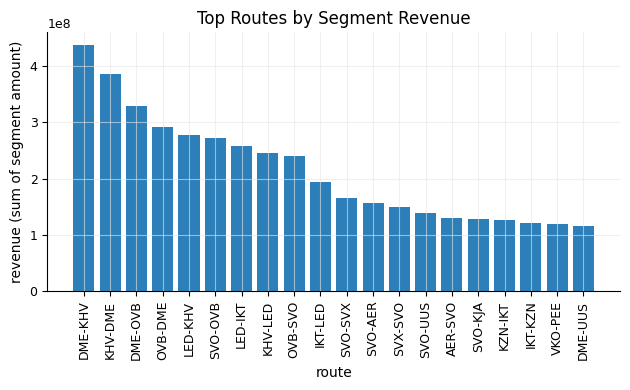

,route_code,amount
62,DME-KHV,438603200
139,KHV-DME,386376300
77,DME-OVB,329121100
254,OVB-DME,292724000
181,LED-KHV,277948500


In [6]:
tf = tables["ticket_flights"].copy()
fl = tables["flights"].copy()

# Keep arrived flights to avoid cancelled/unknown segments
fl["status"] = fl["status"].astype(str).str.upper()
fl = fl[fl["status"] == "ARRIVED"]

# Join segment price with route info
df = tf.merge(
    fl[["flight_id","departure_airport","arrival_airport"]],
    on="flight_id", how="inner", validate="many_to_one"
)
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
df["route_code"] = df["departure_airport"].astype(str) + "-" + df["arrival_airport"].astype(str)

route_rev = (
    df.groupby("route_code", as_index=False)["amount"]
      .sum()
      .sort_values("amount", ascending=False)
      .head(20)
)

# Bar chart (matplotlib)
fig = plt.figure()
plt.bar(route_rev["route_code"], route_rev["amount"])
plt.title("Top Routes by Segment Revenue")
plt.xlabel("route")
plt.ylabel("revenue (sum of segment amount)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(FIG_DIR/"figure_2_3_2_top_routes_by_revenue.png", dpi=150)
plt.show()

# Save the table for the report
route_rev.to_csv(TAB_DIR/"table_2_3_2_top_routes_by_revenue.csv", index=False)
route_rev.head()


In [7]:
tf = tables["ticket_flights"].copy()
tf["fare_conditions"] = tf["fare_conditions"].astype("string").str.strip().str.title()
tf["amount"] = pd.to_numeric(tf["amount"], errors="coerce")

# Summary table for the appendix
fare_summary = (tf.groupby("fare_conditions")["amount"]
                  .describe()[["count","mean","50%","min","max"]]
                  .rename(columns={"50%":"median"})
                  .reset_index())
fare_summary.to_csv(TAB_DIR/"table_2_3_3_fare_class_price_summary.csv", index=False)
fare_summary

# Boxplot by fare class (clip 99th percentile for readability)
groups = ["Economy","Comfort","Business"]
data, labels = [], []
for g in groups:
    s = tf.loc[tf["fare_conditions"]==g, "amount"].dropna()
    if not s.empty:
        data.append(s.clip(upper=tf["amount"].quantile(0.99)))
        labels.append(g)

box(
    data=data, labels=labels,
    title="Ticket Price Distribution by Fare Class",
    outfile=str(FIG_DIR/"figure_2_3_3_ticket_price_by_fare_class.png"),
    ylabel="segment amount"
)


In [8]:
tf = tables["ticket_flights"].copy()
fl = tables["flights"].copy()

fl["status"] = fl["status"].astype(str).str.upper()
fl = fl[fl["status"] == "ARRIVED"]
fl["scheduled_departure"] = to_utc(fl["scheduled_departure"])
fl["scheduled_arrival"]   = to_utc(fl["scheduled_arrival"])

seg = tf.merge(
    fl[["flight_id","scheduled_departure","scheduled_arrival"]],
    on="flight_id", how="inner", validate="many_to_one"
)
seg["amount"] = pd.to_numeric(seg["amount"], errors="coerce")
seg["dur_min"] = minutes_between(seg["scheduled_departure"], seg["scheduled_arrival"])

sample = seg[["dur_min","amount"]].dropna()
if len(sample) > 10000:
    sample = sample.sample(10000, random_state=42)

scatter(
    x=sample["dur_min"], y=sample["amount"],
    title="Flight Duration vs Segment Amount",
    outfile=str(FIG_DIR/"figure_2_3_4_duration_vs_amount.png"),
    xlabel="duration (min)", ylabel="segment amount"
)


In [9]:
bookings = tables["bookings"].copy()
tf = tables["ticket_flights"].copy()

bookings["total_amount"] = pd.to_numeric(bookings["total_amount"], errors="coerce")
tf["amount"]            = pd.to_numeric(tf["amount"], errors="coerce")

b = bookings["total_amount"].dropna()
t = tf["amount"].dropna()

b_clip = b.clip(upper=b.quantile(0.99))
t_clip = t.clip(upper=t.quantile(0.99))

box(
    data=[b_clip, t_clip], labels=["booking total","segment amount"],
    title="Box Plots of Monetary Fields",
    outfile=str(FIG_DIR/"figure_2_4_1_boxplots_monetary.png"),
    ylabel="amount"
)

pd.DataFrame({
    "metric": ["booking_total_mean","segment_amount_mean","booking_total_median","segment_amount_median"],
    "value":  [b.mean(), t.mean(), b.median(), t.median()]
}).to_csv(TAB_DIR/"table_2_4_1_amount_summary.csv", index=False)


In [10]:
dq_rows = []

# bookings
bk = tables.get("bookings", pd.DataFrame()).copy()
if not bk.empty:
    bk["total_amount"] = pd.to_numeric(bk["total_amount"], errors="coerce")
    dq_rows += [
        ("bookings","row_count", len(bk)),
        ("bookings","duplicate_book_ref", int(bk["book_ref"].duplicated().sum())),
        ("bookings","share_negative_total", float((bk["total_amount"] < 0).mean())),
        ("bookings","share_zero_total",     float((bk["total_amount"] == 0).mean())),
        ("bookings","share_missing_book_date", float(bk["book_date"].isna().mean())),
    ]

# ticket_flights
tf = tables.get("ticket_flights", pd.DataFrame()).copy()
if not tf.empty:
    tf["amount"] = pd.to_numeric(tf["amount"], errors="coerce")
    dq_rows += [
        ("ticket_flights","row_count", len(tf)),
        ("ticket_flights","share_missing_amount", float(tf["amount"].isna().mean())),
        ("ticket_flights","share_negative_amount", float((tf["amount"] < 0).mean())),
        ("ticket_flights","share_missing_fare_class", float(tf["fare_conditions"].isna().mean())),
    ]

# flights
fl = tables.get("flights", pd.DataFrame()).copy()
if not fl.empty:
    fl["scheduled_departure"] = to_utc(fl["scheduled_departure"])
    fl["scheduled_arrival"]   = to_utc(fl["scheduled_arrival"])
    dur = (fl["scheduled_arrival"] - fl["scheduled_departure"]).dt.total_seconds()/60.0
    dq_rows += [
        ("flights","row_count", len(fl)),
        ("flights","share_missing_sched_dep", float(fl["scheduled_departure"].isna().mean())),
        ("flights","share_missing_sched_arr", float(fl["scheduled_arrival"].isna().mean())),
        ("flights","share_negative_sched_duration", float((dur < 0).mean())),
    ]

dq = pd.DataFrame(dq_rows, columns=["table","metric","value"])
dq.to_csv(TAB_DIR/"table_2_4_2_data_quality_scorecard.csv", index=False)
dq


,table,metric,value
0,bookings,row_count,262788.0
1,bookings,duplicate_book_ref,0.0
2,bookings,share_negative_total,0.0
3,bookings,share_zero_total,0.0
4,bookings,share_missing_book_date,0.0
5,ticket_flights,row_count,1045726.0
6,ticket_flights,share_missing_amount,0.0
7,ticket_flights,share_negative_amount,0.0
8,ticket_flights,share_missing_fare_class,0.0
9,flights,row_count,33121.0


In [11]:
ap = tables.get("airports_data", pd.DataFrame()).copy()
if not ap.empty and "airport_name" in ap.columns:
    ap["airport_name_en"] = parse_json_en(ap["airport_name"])
    ex = ap[["airport_code","airport_name","airport_name_en"]].head(10)
    ex.to_csv(TAB_DIR/"table_2_4_3_json_parsing_examples.csv", index=False)
    ex
else:
    print("airports_data.airport_name not found; skipped JSON parsing examples.")


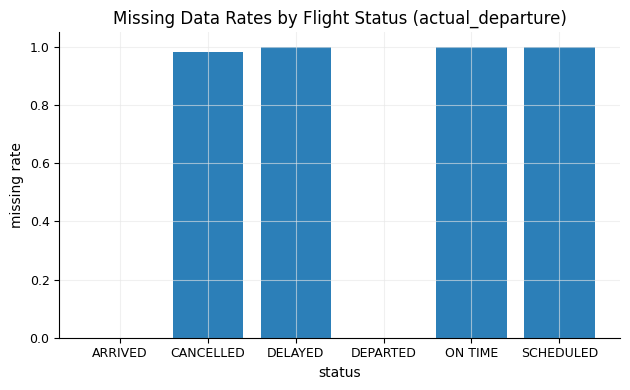

In [12]:
fl = tables["flights"].copy()
fl["status"] = fl["status"].astype(str).str.upper()
fl["actual_departure"] = to_utc(fl["actual_departure"])
fl["actual_arrival"]   = to_utc(fl["actual_arrival"])

miss_by_status = fl.groupby("status").agg(
    missing_actual_departure=("actual_departure", lambda s: float(s.isna().mean())),
    missing_actual_arrival=("actual_arrival",   lambda s: float(s.isna().mean())),
).reset_index()

miss_by_status.to_csv(TAB_DIR/"table_2_4_4_missing_by_status.csv", index=False)
miss_by_status

# plot (actual_departure missing rate)
fig = plt.figure()
plt.bar(miss_by_status["status"], miss_by_status["missing_actual_departure"])
plt.title("Missing Data Rates by Flight Status (actual_departure)")
plt.xlabel("status"); plt.ylabel("missing rate")
plt.tight_layout(); plt.savefig(FIG_DIR/"figure_2_4_4_missing_by_status_dep.png", dpi=150); plt.show()


In [13]:
keys = ["book_ref","ticket_no","flight_id"]
rows = []
for name, df in tables.items():
    for k in keys:
        if k in df.columns:
            rows.append((name, k, str(df[k].dtype), int(df[k].isna().sum())))
join_keys = pd.DataFrame(rows, columns=["table","key","dtype","n_missing"])
join_keys.to_csv(TAB_DIR/"table_2_4_5_join_key_dtypes.csv", index=False)
join_keys.head(10)


,table,key,dtype,n_missing
0,bookings,book_ref,object,0
1,tickets,book_ref,object,0
2,tickets,ticket_no,object,0
3,ticket_flights,ticket_no,object,0
4,ticket_flights,flight_id,int64,0
5,flights,flight_id,int64,0
6,boarding_passes,ticket_no,object,0
7,boarding_passes,flight_id,int64,0


 
**Done for Steps 2.3–2.4.**  
Next: open `02_data_preparation.ipynb` for Steps 3.1–3.5 (selection, cleaning, construction, integration, formatting to booking-level table).
